In [1]:
from sklearn.datasets import fetch_california_housing
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.inspection import plot_partial_dependence, partial_dependence
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
california = fetch_california_housing()
X = pd.DataFrame(california.data.astype('float32'), columns=california.feature_names)
y = california.target

In [3]:
TEST_SIZE = 0.2
RANDOM_SEED = 2020
N_FOLD = 5

# PD & ICE for all instance
see also: https://scikit-learn.org/stable/modules/generated/sklearn.inspection.plot_partial_dependence.html

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, shuffle=True, random_state=RANDOM_SEED)

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    importance_type="gain", # TODO: check 'weight' and 'cover'
    random_state=RANDOM_SEED,
)
evals_result = {}
model.fit(
    X=X_train,
    y=y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=5,
    verbose=10,
    eval_metric='rmse',
    callbacks=[xgb.callback.record_evaluation(evals_result)],
)

pred = model.predict(X_test)

Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.
Will train until validation_1-rmse hasn't improved in 5 rounds.
[0]	validation_0-rmse:1.43900	validation_1-rmse:1.44776
[10]	validation_0-rmse:0.47500	validation_1-rmse:0.52740
[20]	validation_0-rmse:0.41523	validation_1-rmse:0.49083


/Users/ryotaro.shimizu/.pyenv/versions/3.7.9/lib/python3.7/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[30]	validation_0-rmse:0.37941	validation_1-rmse:0.47939
[40]	validation_0-rmse:0.35717	validation_1-rmse:0.47417
Stopping. Best iteration:
[38]	validation_0-rmse:0.35895	validation_1-rmse:0.47411


In [5]:
print(f"RMSE: {mean_squared_error(y_test, pred, squared=False)}")
print(f"R^2: {r2_score(y_test, pred)}")

RMSE: 0.4741107130369501
R^2: 0.8340943552033905


In [6]:
X.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

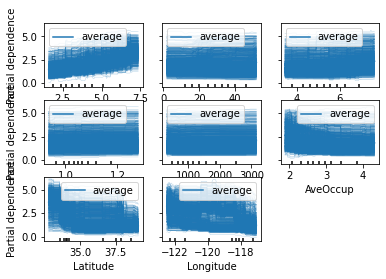

In [7]:
plot_partial_dependence(
    estimator=model,
    X=X_test,
    features=X.columns.tolist(),
#     features=['MedInc', 'HouseAge'],
    kind='both',
)

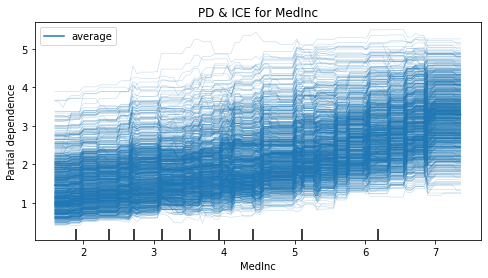

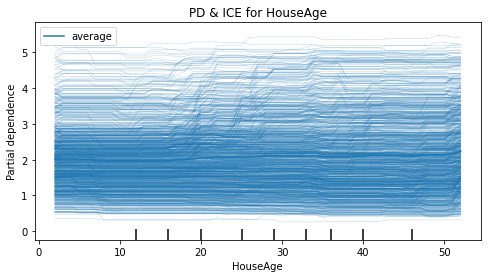

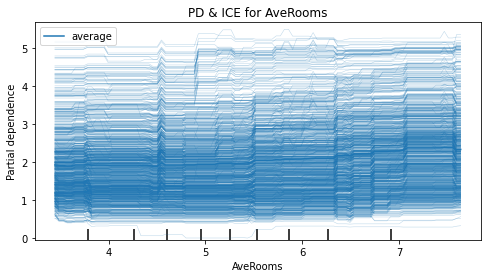

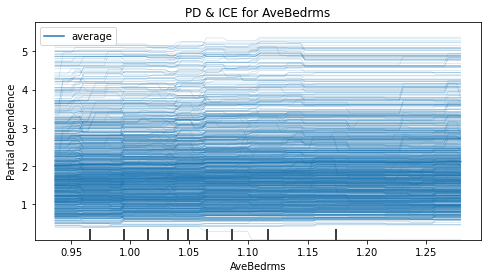

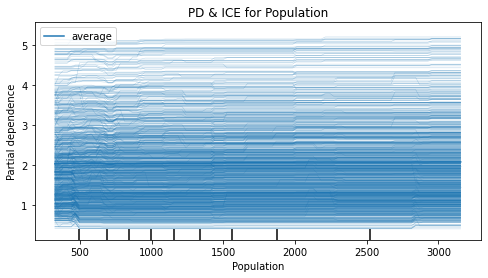

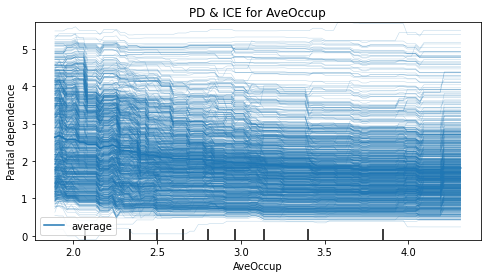

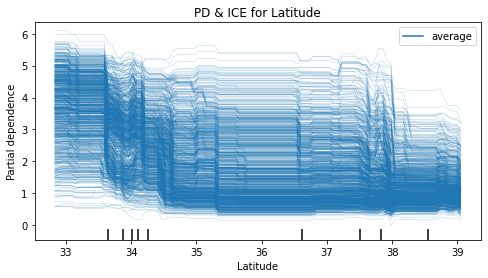

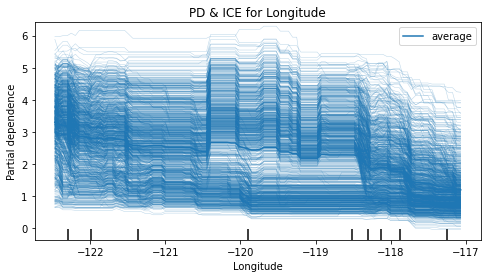

In [8]:
for col in X.columns:
    _, ax = plt.subplots(figsize=(8, 4))
    ax.set_title(f"PD & ICE for {col}")

    plot_partial_dependence(
        estimator=model,
        X=X_test,
        features=[col],
        kind='both',
        ax=ax,
    )

# PD

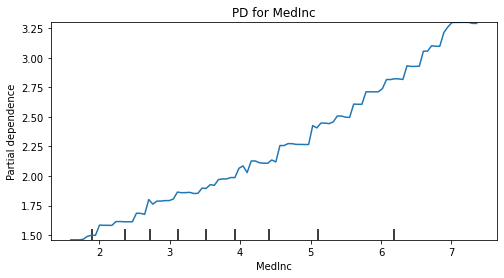

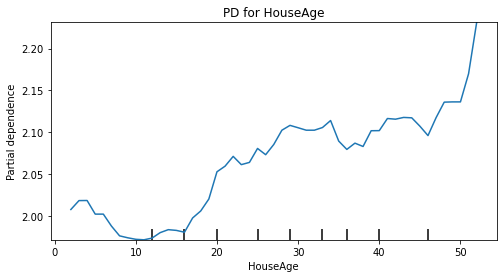

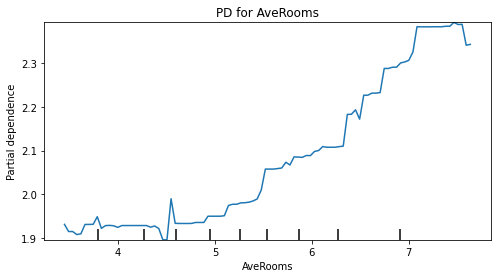

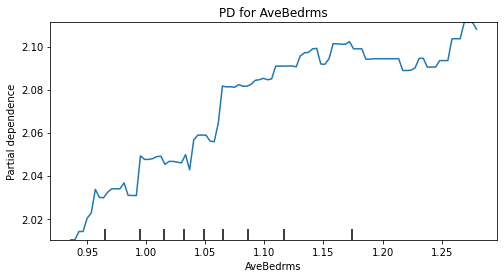

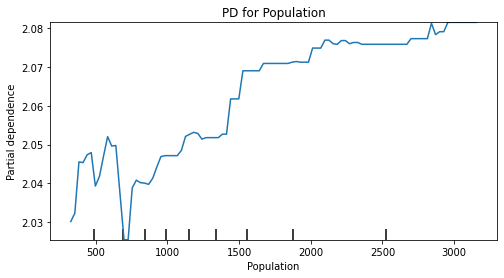

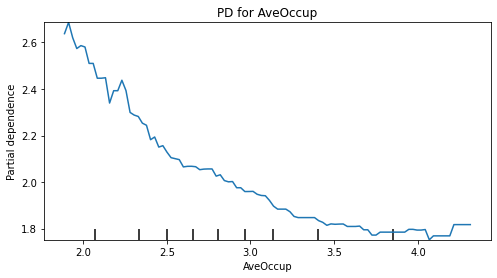

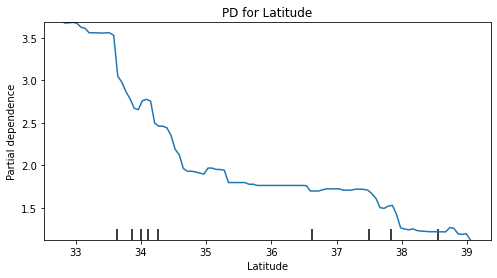

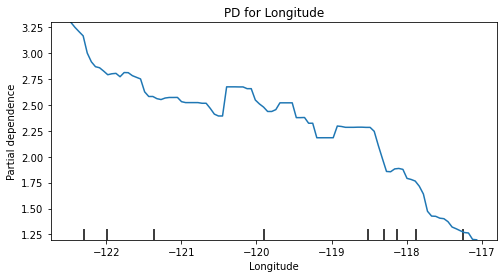

In [9]:
for col in X.columns:
    _, ax = plt.subplots(figsize=(8, 4))
    ax.set_title(f"PD for {col}")

    plot_partial_dependence(
        estimator=model,
        X=X_test,
        features=[col],
        kind='average',
        ax=ax,
    )

# ICE for a certain instance
see also: https://scikit-learn.org/stable/modules/generated/sklearn.inspection.partial_dependence.html

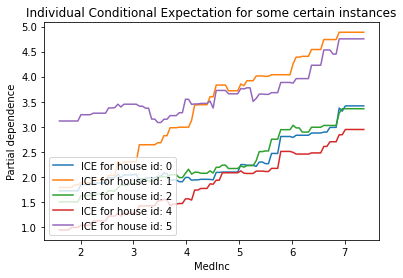

In [10]:
col = 'MedInc'
ice = partial_dependence(
    estimator=model,
    X=X_test,
    features=[col],
    kind='individual',
)
x = ice['values'][0]

for idx in [0, 1, 2, 4, 5]:
    plt.xlabel(col, fontsize=10)
    plt.ylabel("Partial dependence", fontsize=10)
    plt.plot(x, ice.individual[0, idx], label=f"ICE for house id: {idx}")
    plt.legend(loc="lower left", fontsize=10)
    plt.title("Individual Conditional Expectation for some certain instances")